# Machine Learning - Project 1

>Dimitrios Stefanou

>A.M. 3160245

### Package imports and data loading

In [1]:
import pandas as pd
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
from six.moves import cPickle as pickle
import os
import platform
from subprocess import check_output

### Load Mnist
>Load either Mnist or CIFAR

In [2]:
def load_data():
    """
    Load the MNIST dataset. Reads the training and testing files and create matrices.
    :Expected return:
    train_data:the matrix with the training data
    test_data: the matrix with the data that will be used for testing
    y_train: the matrix consisting of one 
                        hot vectors on each row(ground truth for training)
    y_test: the matrix consisting of one
                        hot vectors on each row(ground truth for testing)
    """

    # load the train files
    df = None

    y_train = []

    for i in range(10):
        tmp = pd.read_csv('mnistdata/train%d.txt' % i, header=None, sep=" ")
        # build labels - one hot vector
        hot_vector = [1 if j == i else 0 for j in range(0, 10)]

        for j in range(tmp.shape[0]):
            y_train.append(hot_vector)
        # concatenate dataframes by rows
        if i == 0:
            df = tmp
        else:
            df = pd.concat([df, tmp])

    train_data = df.values
    y_train = np.array(y_train)

    # load test files
    df = None

    y_test = []

    for i in range(10):
        tmp = pd.read_csv('mnistdata/test%d.txt' % i, header=None, sep=" ")
        # build labels - one hot vector

        hot_vector = [1 if j == i else 0 for j in range(0, 10)]

        for j in range(tmp.shape[0]):
            y_test.append(hot_vector)
        # concatenate dataframes by rows
        if i == 0:
            df = tmp
        else:
            df = pd.concat([df, tmp])

    test_data = df.values
    y_test = np.array(y_test)

    return train_data, test_data, y_train, y_test


X_train, X_test, y_train, y_test = load_data()
X_train = X_train.astype(float) / 255
X_test = X_test.astype(float) / 255

# Add bias
X_train = np.hstack((np.ones((X_train.shape[0], 1)), X_train))
X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (60000, 785)
Train labels shape:  (60000, 10)
Test data shape:  (10000, 785)
Test labels shape:  (10000, 10)


### Load CIFAR-10

In [24]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

img_rows, img_cols = 32, 32
input_shape = (img_rows, img_cols, 3)
def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))

def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = load_pickle(f)
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000,3072)
        Y = np.array(Y)
        return X, Y

def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for batch in range(1,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (batch, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte
def get_CIFAR10_data(num_training=50000, num_test=10000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cifar'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    X_train = X_train.astype(float) / 255
    X_test = X_test.astype(float) / 255
    
    # Add bias
    X_train = np.hstack((np.ones((X_train.shape[0], 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))
    # One hot encode
    y_train = pd.get_dummies(y_train).to_numpy()
    y_test = pd.get_dummies(y_test).to_numpy()

    return X_train, y_train, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_test, y_test = get_CIFAR10_data()

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (50000, 3073)
Train labels shape:  (50000, 10)
Test data shape:  (10000, 3073)
Test labels shape:  (10000, 10)
[[1.         0.23137255 0.16862745 ... 0.54901961 0.32941176 0.28235294]
 [1.         0.60392157 0.49411765 ... 0.54509804 0.55686275 0.56470588]
 [1.         1.         0.99215686 ... 0.3254902  0.3254902  0.32941176]
 ...
 [1.         0.1372549  0.15686275 ... 0.30196078 0.25882353 0.19607843]
 [1.         0.74117647 0.72941176 ... 0.6627451  0.67058824 0.67058824]
 [1.         0.89803922 0.9254902  ... 0.67843137 0.63529412 0.63137255]]


### Activation functions (and derivatives)

In [3]:
def softmax(z, ax=1):
    m = np.max(z, axis=ax, keepdims=True)  # max per row
    p = np.exp(z - m)
    return p / np.sum(p, axis=ax, keepdims=True)


def act(z, act_num):
    return {
        1: np.log(1. + np.exp(z)),
        2: np.tanh(z),
        3: np.cos(z)
    }.get(act_num, 'Wrong activation number (will likely throw error).')


def act_prime(z, act_num):
    return {
        1: np.exp(z) / (1. + np.exp(z)),
        2: 1. - np.square(np.tanh(z)),
        3: -1. * np.sin(z)
    }.get(act_num, 'Wrong activation number (will likely throw error).')

### Forward/Back probagation and cost function

In [4]:
def cost_grad_softmax(W1, W2, X, y, act_num, lamda):
    # Forward probagation
    z1 = X.dot(W1.T)
    a1 = act(z1, act_num)
    z2 = a1.dot(W2.T)
    max_error = np.max(z2, axis=1)
    y_hat = softmax(z2)

    # Compute the cost function to check convergence
    # using the logsumexp trick for numerical stability - lec8.pdf slide 43
    Ew = np.sum(y * z2) - np.sum(max_error) - \
         np.sum(np.log(np.sum(np.exp(z2 - np.array([max_error, ] * z2.shape[1]).T), 1))) - \
         (0.5 * lamda) * np.sum(np.square(W2))

    # Backprobagation
    # Gradient for W2 - calculate (T - Y).T*Z - λ*W2
    d_z2 = (y - y_hat)
    dew2dw2 = np.dot(d_z2.T, a1) - lamda * W2

    # Gradient for W1 - calculate ((T - Y)*W2 * Z').T*X - λ*W1
    d_a1 = np.dot(d_z2, W2)
    d_z1 = np.multiply(d_a1, act_prime(z1, act_num))
    dew1dw1 = np.dot(d_z1.T, X) - lamda * W1

    return Ew, dew1dw1, dew2dw2

### Train function - mini batch gradient ascent, cost calculations

In [5]:
def ml_softmax_train(X, y, lamda, W1_init, W2_init, options):
    W1 = W1_init
    W2 = W2_init
    # Maximum number of iteration of gradient ascend
    _iter = options[0]
    # Tolerance
    tol = options[1]
    # Learning rate
    eta = options[2]
    # Activation function
    act_num = options[3]
    # Batch size
    batch_size = options[4]

    Ew = 0
    Ewold = -np.inf
    costs = []

    for i in range(1, _iter + 1):
        rng_state = np.random.get_state()
        np.random.shuffle(X)
        np.random.set_state(rng_state)
        np.random.shuffle(y)
        X_batch = np.array_split(X, batch_size)
        y_batch = np.array_split(y, batch_size)
        for m in range(0, batch_size):
            Ew, gradEw1, gradEw2 = cost_grad_softmax(W1, W2, X_batch[m], y_batch[m], act_num, lamda)
            # Update parameters based on gradient ascend
            W1 = W1 + eta * gradEw1
            W2 = W2 + eta * gradEw2
            
            # Break if you achieve the desired accuracy in the cost function
            if np.abs(Ew - Ewold) < tol:
                break
            Ewold = Ew

        # Show the current cost function on screen
        if i % 50 == 0:
            print('Iteration :%d, Cost function :%f' % (i, Ew))
        # save cost of last batch
        costs.append(Ew)

    return W1, W2, costs

### Predict function 

In [6]:
def predict(X, act_num):
    z1 = X.dot(W1.T)
    a1 = act(z1, act_num)
    z2 = a1.dot(W2.T)
    y_hat = softmax(z2)
    y_pred = np.argmax(y_hat, 1)
    return y_pred

### Gradient Check function - not working, to be done

In [7]:
def gradcheck_softmax(W1_init, W2_init, X, t, act_num, lamda):
    
    W1 = W1_init
    W2 = W2_init
    epsilon = 1e-7
    
    _list = np.random.randint(X.shape[0], size=5)
    x_sample = np.array(X[_list, :])
    t_sample = np.array(t[_list, :])
    
    Ew, gradEw1, gradEw2 = cost_grad_softmax(W1, W2, x_sample, t_sample, act_num, lamda)
    
    numericalGrad = np.zeros(gradEw2.shape)
    # Compute all numerical gradient estimates and store them in
    # the matrix numericalGrad
    for k in range(gradEw1.shape[0]):
        for d in range(gradEw1.shape[1]):
            for l in range(numericalGrad.shape[0]):
            
                #add epsilon to the w1[k,d], w2[l,k]
                w1_tmp = np.copy(W1)
                w2_tmp = np.copy(W2)
                w1_tmp[k, d] += epsilon
                w2_tmp[l, k] += epsilon
                e_plus, _, _ = cost_grad_softmax(w1_tmp, w2_tmp, x_sample, t_sample, act_num, lamda)

                #subtract epsilon to the w1[k,d], w2[l,k]
                w1_tmp = np.copy(W1)
                w2_tmp = np.copy(W2)
                w1_tmp[k, d] -= epsilon
                w2_tmp[l, k] -= epsilon
                e_minus, _, _ = cost_grad_softmax(w1_tmp, w2_tmp, x_sample, t_sample, act_num, lamda)

                #approximate gradient ( E[ w[k,d] + theta ] - E[ w[k,d] - theta ] ) / 2*e
                numericalGrad[l, k] = (e_plus - e_minus) / (2 * epsilon)
    
    return (gradEw2, numericalGrad)

### Hyperparameter and weights initialization

In [11]:
# data_size is the num of train samples, input_layer_size is the num of pixels + 1 (bias)
data_size, input_layer_size = X_train.shape
hid_layer_size = input_layer_size//10 + 1
out_layer_size = 10

# Weight initialization with heuristic function
W1 = np.random.rand(hid_layer_size, input_layer_size) * np.sqrt(1. / (input_layer_size + hid_layer_size))
W2 = np.random.rand(out_layer_size, hid_layer_size) * np.sqrt(1. / (hid_layer_size + out_layer_size))

# regularization parameter
lamda = 0.1

# Maximum number of iterations, tolerance, \
# learning rate, activation function number(1: log, 2:tanh, 3:cos),
# batch size
options = [200, 1e-4, 0.5/data_size, 2, 100]

### Gradient Checking

In [ ]:
gradEw2, numericalGrad = gradcheck_softmax(W1, W2, X_train, y_train, options[3], lamda)

# Absolute norm
print("The difference estimate for the gradient is: ", np.max(np.abs(gradEw2 - numericalGrad)))

### NN training and cost plot

Iteration :50, Cost function :-446.299250
Iteration :100, Cost function :-252.124729
Iteration :150, Cost function :-178.440974
Iteration :200, Cost function :-204.215241


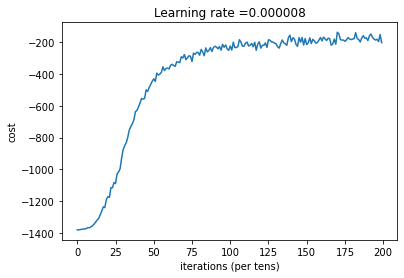

In [12]:
# Re-initialize weight for training
W1 = np.random.rand(hid_layer_size, input_layer_size) * np.sqrt(1. / (input_layer_size + hid_layer_size))
W2 = np.random.rand(out_layer_size, hid_layer_size) * np.sqrt(1. / (hid_layer_size + out_layer_size))
W1, W2, costs = ml_softmax_train(X_train, y_train, lamda, W1, W2, options)

plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations (per tens)')
plt.title("Learning rate =" + str(format(options[2], 'f')))
plt.show()

### Accuracy

In [13]:
y_pred = predict(X_test, options[3])

acc = np.mean(y_pred == np.argmax(y_test, 1))
print("accuracy ", acc)

accuracy  0.9208
